In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, f1_score  # Added f1_score import
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 🔄 Chargement des données
df = pd.read_csv("kiali_kpi_metrics.csv")

# 🧽 Nettoyage de time_window
df['time_window'] = df['time_window'].astype(str).str.strip()
df = df[df['time_window'] == "15S"].copy()

if df.empty:
    raise ValueError("🚨 Aucun enregistrement avec time_window == '15s'. Vérifiez le fichier CSV.")

# ✅ Nettoyage des colonnes numériques
df['error_rate'] = pd.to_numeric(df['error_rate'], errors='coerce').fillna(0.0)

# 🏷️ Attribution du statut
def assign_status(er):
    if er < 0.01:
        return 0
    elif er < 0.1:
        return 1
    else:
        return 2

def assign_status(er):
    if er < 0.15:
        return 0
    
    else:
        return 1



df['status'] = df['error_rate'].apply(assign_status)
df.drop(df[df['istio_request_bytes'] == 0.0].index, inplace = True)
df.drop(df[df['new_request'] < 0.0].index, inplace = True)
df = df.dropna(subset=["request_rate"])
df.to_csv("data2.csv", index=False)







class MicroserviceDataset:
    def __init__(self, df, node_map, features, target):
        self.df = df
        self.node_map = node_map
        self.features = features
        self.target = target
        
    def __len__(self):
        return 1  # We'll treat the whole dataset as one graph
    
    def __getitem__(self, idx):
        edge_index = []
        edge_attr = []
        edge_labels = []
        
        # Create edges with features and labels
        for _, row in self.df.iterrows():
            src = self.node_map[row['source_workload']]
            tgt = self.node_map[row['destination_workload']]
            edge_index.append([src, tgt])
            edge_attr.append(row[self.features].values)
            edge_labels.append(row[self.target])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)
        
        # Create node features (using random features since we don't have node features)
        num_nodes = len(self.node_map)
        x = torch.randn((num_nodes, 16))  # 16-dimensional random features
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)

class EdgePredictorGNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.edge_predictor = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, data):
        # Node embeddings
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        
        # Edge prediction
        src, dst = data.edge_index
        h_src = x[src]
        h_dst = x[dst]
        
        # Combine node embeddings and edge features
        edge_emb = torch.cat([h_src, h_dst, data.edge_attr], dim=1)
        return self.edge_predictor(edge_emb)

def train():
    # Load and preprocess data
    df = pd.read_csv('data2.csv')
    

    df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) / 10**9  # Convert to seconds


    # Prepare features and target
    features = ['throughput', 'request_rate', 'istio_request_bytes', 'average_latency', 'istio_request_bytes', 'new_request', 'timestamp']  # Excluding error_rate and duration_milliseconds
    target = 'status'
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    #df[features] = StandardScaler().fit_transform(df[features])
    
    # Create node mapping
    all_nodes = sorted(list(set(df['source_workload'].unique()).union(set(df['destination_workload'].unique()))))
    node_map = {node: i for i, node in enumerate(all_nodes)}
    
    # Create dataset
    dataset = MicroserviceDataset(df, node_map, features, target)
    
    # Since we have one graph, we'll use a single DataLoader with batch_size=1
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Initialize model
    model = EdgePredictorGNN(
        node_features=16,  # Matches our random node features
        edge_features=len(features),
        hidden_dim=64,
        num_classes=2  # healthy, degraded, error
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(1, 101):
        model.train()
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Print training stats
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d} | Loss: {total_loss/len(loader):.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        data = dataset[0].to(device)
        out = model(data)
        pred = out.argmax(dim=1).cpu().numpy()
        truth = data.y.cpu().numpy()
        
        print("\nClassification Report:")
        print(classification_report(truth, pred, target_names=['healthy', 'degraded']))
        print("Macro F1-score:", f1_score(truth, pred, average='macro'))

if __name__ == "__main__":
    train()



Epoch 010 | Loss: 0.0043
Epoch 020 | Loss: 0.0000
Epoch 030 | Loss: 0.0000
Epoch 040 | Loss: 0.0000
Epoch 050 | Loss: 0.0000
Epoch 060 | Loss: 0.0000
Epoch 070 | Loss: 0.0000
Epoch 080 | Loss: 0.0000
Epoch 090 | Loss: 0.0000
Epoch 100 | Loss: 0.0000

Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      1120
    degraded       1.00      1.00      1.00        80

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Macro F1-score: 1.0


Epoch 1 | Loss: 0.6869
Epoch 2 | Loss: 0.1012
Epoch 3 | Loss: 0.0245
Epoch 4 | Loss: 0.0007
Epoch 5 | Loss: 0.0000
Epoch 6 | Loss: 0.0000
Epoch 7 | Loss: 0.0000
Epoch 8 | Loss: 0.0000
Epoch 9 | Loss: 0.0000
Epoch 10 | Loss: 0.0000
Epoch 11 | Loss: 0.0000
Epoch 12 | Loss: 0.0000
Epoch 13 | Loss: 0.0000
Epoch 14 | Loss: 0.0000
Epoch 15 | Loss: 0.0000
Epoch 16 | Loss: 0.0000
Epoch 17 | Loss: 0.0000
Epoch 18 | Loss: 0.0000
Epoch 19 | Loss: 0.0000
Epoch 20 | Loss: 0.0000
Epoch 21 | Loss: 0.0000
Epoch 22 | Loss: 0.0000
Epoch 23 | Loss: 0.0000
Epoch 24 | Loss: 0.0000
Epoch 25 | Loss: 0.0000
Epoch 26 | Loss: 0.0000
Epoch 27 | Loss: 0.0000
⏹ Early stopping triggered


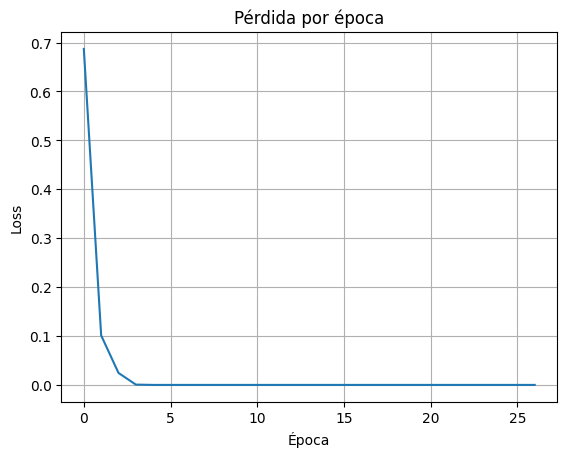

\nClassification Report:
              precision    recall  f1-score   support

   saludable       1.00      1.00      1.00      1120
   degradado       1.00      1.00      1.00        80

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Macro F1-score: 1.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from collections import Counter

# 📥 Cargar datos
df = pd.read_csv("kiali_kpi_metrics.csv")
df['time_window'] = df['time_window'].astype(str).str.strip()
df = df[df['time_window'] == "15S"].copy()
df['error_rate'] = pd.to_numeric(df['error_rate'], errors='coerce').fillna(0.0)
df = df[df['istio_request_bytes'] != 0.0]
df = df[df['new_request'] >= 0.0]
df = df.dropna(subset=["request_rate"])
df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) / 10**9

# # 🏷 Etiquetas multiclase
# def assign_status(er):
#     if er < 0.01:
#         return 0
#     elif er < 0.15:
#         return 1
#     else:
#         return 2
# Modificar la función de etiquetado
def assign_status(er):
    if er < 0.15:  # Clase 0: saludable
        return 0
    else:          # Clase 1: degradado
        return 1
df['status'] = df['error_rate'].apply(assign_status)

# 🎛 Normalización
features = ['throughput', 'request_rate', 'istio_request_bytes', 'average_latency', 'istio_request_bytes', 'new_request', 'timestamp']  # Excluding error_rate and duration_milliseconds
df[features] = MinMaxScaler().fit_transform(df[features])
target = 'status'

# 🔀 Mapeo de nodos y estadísticas como embeddings
all_nodes = sorted(set(df['source_workload']).union(df['destination_workload']))
node_map = {node: i for i, node in enumerate(all_nodes)}

# Crear embeddings reales de nodos
node_stats = df.groupby('source_workload')[features].mean()
x_features = np.zeros((len(node_map), len(features)))
for node, idx in node_map.items():
    if node in node_stats.index:
        x_features[idx] = node_stats.loc[node].values
    else:
        x_features[idx] = np.random.rand(len(features))  # fallback aleatorio

x_tensor = torch.tensor(x_features, dtype=torch.float)

# 🔁 Dataset
class MicroserviceDataset:
    def __init__(self, df, node_map, features, target):
        self.df = df
        self.node_map = node_map
        self.features = features
        self.target = target

    def __len__(self): return 1

    def __getitem__(self, idx):
        edge_index, edge_attr, edge_labels = [], [], []

        for _, row in self.df.iterrows():
            src = self.node_map[row['source_workload']]
            tgt = self.node_map[row['destination_workload']]
            edge_index.append([src, tgt])
            edge_attr.append(row[self.features].values)
            edge_labels.append(row[self.target])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)

        return Data(x=x_tensor, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)

# 🧠 Modelo
class EdgePredictorGNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.edge_predictor = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        src, dst = data.edge_index
        h_src = x[src]
        h_dst = x[dst]
        edge_emb = torch.cat([h_src, h_dst, data.edge_attr], dim=1)
        return self.edge_predictor(edge_emb)

# ⚙️ Configuración y entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = MicroserviceDataset(df, node_map, features, target)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = EdgePredictorGNN(7, 7, 64, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 🧮 Pesos de clases
class_counts = Counter(df['status'])
total = sum(class_counts.values())
weights = [total / class_counts[i] for i in range(2)]
weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# 🚂 Entrenamiento + logging
losses = []
best_loss = float("inf")
patience = 20
wait = 0

for epoch in range(1, 301):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch} | Loss: {total_loss:.4f}")
    
    # Early stopping
    if total_loss < best_loss:
        best_loss = total_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping triggered")
            break

# 📈 Gráfico de pérdida
plt.plot(losses)
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 📊 Evaluación
model.eval()
with torch.no_grad():
    data = dataset[0].to(device)
    out = model(data)
    pred = out.argmax(dim=1).cpu().numpy()
    truth = data.y.cpu().numpy()
    print("\\nClassification Report:")
    print(classification_report(truth, pred, target_names=['saludable', 'degradado']))
    print("Macro F1-score:", f1_score(truth, pred, average='macro'))

